Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

**DANIEL DELGADO - FABIAN SALAZAR FIGUEROA**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 15 de Septiembre a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [ ]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [ ]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

## **3. EDA**

### 3.1 Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [ ]:
data.info()

In [ ]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

In [ ]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

### 3.2 Ahora debemos convertir en índice la variable sin nombre: 'Unnamed: 0'  que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [ ]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a una fecha
def convertir_mes_a_fecha(mes, start_date):
    # Calcular el año y el mes correspondientes
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    return datetime(year, month, 1)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha(x, start_date))

print(data)


In [ ]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

In [ ]:
#miramos nuevamente como queda el dataframe con estas transformaciones
data.info()

In [ ]:
data.shape

In [ ]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

In [ ]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

### 3.3 Ya con esta pequeñas transformaciones tenemos nuestro conjunto de datos listo para trabajarlo y proceder a hacer todo lo necesario para llevar a cabo los pronósticos de cada serie de tiempo de los dos prodcutos estrellas de la empresa

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

### 3.4 Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

In [ ]:
#Componentes serie de tiempo prodcuto1
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie de producto1, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto1

In [ ]:
td_componentes_producto1.seasonal

In [ ]:
td_componentes_producto1.trend

In [ ]:
td_componentes_producto1.resid

In [ ]:
#Componentes serie de tiempo prodcuto2
td_componentes_producto2 = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes_producto2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie producto2, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto2

In [ ]:
td_componentes_producto2.seasonal

In [ ]:
td_componentes_producto2.trend

In [ ]:
td_componentes_producto2.resid

Procedemos a realizar una gráfica para comparar ambas series donde vemos el comportamiento de cada producto respecto al otro

In [ ]:
# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))

# Graficar los componentes de producto1
axes[0, 0].plot(td_componentes_producto1.observed)
axes[0, 0].set_title('Producto 1 - Observado')
axes[1, 0].plot(td_componentes_producto1.trend)
axes[1, 0].set_title('Producto 1 - Tendencia')
axes[2, 0].plot(td_componentes_producto1.seasonal)
axes[2, 0].set_title('Producto 1 - Estacionalidad')
axes[3, 0].plot(td_componentes_producto1.resid)
axes[3, 0].set_title('Producto 1 - Residual')

# Graficar los componentes de producto2
axes[0, 1].plot(td_componentes_producto2.observed)
axes[0, 1].set_title('Producto 2 - Observado')
axes[1, 1].plot(td_componentes_producto2.trend)
axes[1, 1].set_title('Producto 2 - Tendencia')
axes[2, 1].plot(td_componentes_producto2.seasonal)
axes[2, 1].set_title('Producto 2 - Estacionalidad')
axes[3, 1].plot(td_componentes_producto2.resid)
axes[3, 1].set_title('Producto 2 - Residual')

# Ajustar el layout
plt.tight_layout()
plt.show()

Aquí notamos que la tendencia de cada producto ha sido inversa es decir: el producto1 tiene una tendencia hacia la baja y el producto2 una tendencia a la alza; pero debemos observar que también a pesar de esto al final ambos prodcutos se encuentran en una ventas similares en cantidad aunque aún vende más el producto1. 

## **4. PROTOCOLOS DE EVALUACION**

Al inicio había hecho un train y test donde el test tenía solo el ultimo dato, pensando en los ejercicios anteriores.. NOta! 

### **4.1 Ventana Recursiva**

En un enfoque de ventana recursiva, entrenas el modelo con un conjunto de datos y luego lo usas para predecir un punto en el futuro. Después de obtener la predicción, amplías la ventana para incluir este nuevo punto y repites el proceso.

![alt text](image.png)

Ejemplo:

In [ ]:
def recursive_forecast(model, train_data, test_data):
    """
    Realiza un pronóstico recursivo con el modelo dado.
    
    Parameters:
    - model: el modelo de pronóstico (debe tener un método `fit` y `predict`)
    - train_data: datos de entrenamiento
    - test_data: datos de prueba
    
    Returns:
    - predictions: lista de predicciones
    """
    predictions = []
    history = train_data.copy()
    
    for t in range(len(test_data)):
        model.fit(history)
        yhat = model.predict(1)
        predictions.append(yhat)
        history = np.append(history, test_data[t])  # actualizamos la ventana
        
    return predictions


### **4.2 Rolling window**

En una rolling window, mueves la ventana a lo largo del tiempo para generar predicciones, entrenando el modelo solo en los datos más recientes.

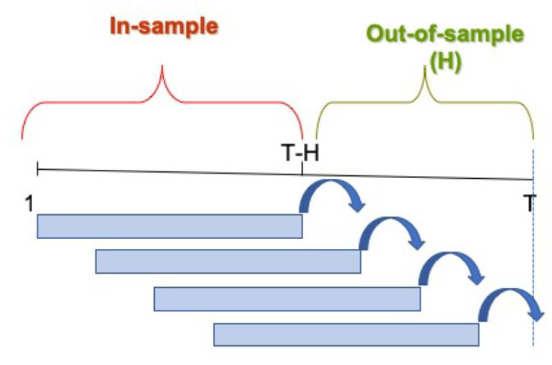

Ejemplo:

In [ ]:
def rolling_forecast(model, train_data, test_data, window_size):
    """
    Realiza un pronóstico utilizando una ventana deslizante (rolling window).
    
    Parameters:
    - model: el modelo de pronóstico (debe tener un método `fit` y `predict`)
    - train_data: datos de entrenamiento
    - test_data: datos de prueba
    - window_size: tamaño de la ventana deslizante
    
    Returns:
    - predictions: lista de predicciones
    """
    predictions = []
    
    for t in range(len(test_data)):
        window = train_data[-window_size:]  # extraemos la ventana
        model.fit(window)
        yhat = model.predict(1)
        predictions.append(yhat)
        train_data = np.append(train_data, test_data[t])  # movemos la ventana
        
    return predictions


Dependiendo del modelo a usar se deben hacer algunos ajustes a las funciones para el correcto funcionamiento del protocolo de evaluación

Se implementan las funciones para evaluar los modelos utilizando ambos protocolos.

In [ ]:
#Definimos nuestras funciones con los protocolos de evaluación a usar
# Evaluación con Rolling Window ajustada
def rolling_window_evaluation(series, model_func, params, window_size=12):
    predictions = []
    for i in range(window_size, len(series)):
        train = series[:i]
        test = series[i:i+1]
        
        model = model_func(train, **params)
        
        if hasattr(model, 'forecast'):
            forecast = model.forecast(steps=1)
            predictions.append(forecast[0])
        else:
            # Para modelos como promedio móvil que no tienen forecast
            predictions.append(model.iloc[-1])  # Usar el último valor de la media móvil
    
    return predictions

# Evaluación con Ventana Recursiva
def recursive_window_evaluation(series, model_func, params, initial_train_size=12):
    predictions = []
    train = series[:initial_train_size].copy()
    
    for i in range(initial_train_size, len(series)):
        model = model_func(train, **params)
        forecast = model.forecast(steps=1)
        predictions.append(forecast[0])
        train = train.append(series[i:i+1])
    
    return predictions

# Calcular RMSE
def calculate_rmse(true_values, predictions):
    return np.sqrt(mean_squared_error(true_values, predictions))

## **5. MODELOS**

Implementaremos funciones para:

- Promedio Móvil.

- Suavización Exponencial (Simple, Holt, Holt-Winters).

- ARIMA.

In [ ]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.arima.model import ARIMA

# Promedio Móvil ajustado
def moving_average_model(series, window):
    return series.rolling(window=window).mean()

# Suavización Exponencial Simple
def exponential_smoothing_model(series, alpha):
    model = ExponentialSmoothing(series, trend=None, seasonal=None)
    fit_model = model.fit(smoothing_level=alpha)
    return fit_model

# Holt
def holt_model(series, alpha, beta):
    model = ExponentialSmoothing(series, trend="add")
    fit_model = model.fit(smoothing_level=alpha, smoothing_slope=beta)
    return fit_model

"""
# Holt-Winters
def holt_winters_model(series, alpha, beta, gamma):
    model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=12)
    fit_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    return fit_model
"""

# Modelo Holt-Winters ajustado
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holt_winters_model(series, alpha, beta, gamma, seasonal_periods=12):
    try:
        model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
        return fitted_model
    except ValueError as e:
        print(f"Error en Holt-Winters: {e}")
        # Si no hay suficientes datos estacionales, retornar un modelo sin componente estacional
        model = ExponentialSmoothing(series, trend='add', seasonal=None)
        fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta)
        return fitted_model



# ARIMA
def arima_model(series, p, d, q):
    model = ARIMA(series, order=(p,d,q))
    fit_model = model.fit()
    return fit_model

Búsqueda de Hiperparámetros y Ejecución

In [ ]:
#Se realizarán pruebas con diferentes combinaciones de parámetros para cada modelo.

# Búsqueda de Hiperparámetros para Holt
#def hyperparameter_search(series, model_name):
def hyperparameter_search(series, model_name, seasonal_periods=12):
    
    if model_name == 'Promedio Movil':
        best_rmse = float('inf')
        best_window = None
        for window in range(2, 13):  # Prueba ventanas de 2 a 12
            predictions = rolling_window_evaluation(series, moving_average_model, {'window': window})
            rmse = calculate_rmse(series[12:], predictions)
            if rmse < best_rmse:
                best_rmse = rmse
                best_window = window
        return best_rmse, best_window

    elif model_name == 'Suavización Exponencial':
        best_rmse = float('inf')
        best_alpha = None
        for alpha in np.linspace(0.1, 1.0, 10):  # Prueba alphas de 0.1 a 1.0
            predictions = rolling_window_evaluation(series, exponential_smoothing_model, {'alpha': alpha})
            rmse = calculate_rmse(series[12:], predictions)
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
        return best_rmse, best_alpha

    elif model_name == 'Holt':
        best_rmse = float('inf')
        best_params = None
        for alpha in np.linspace(0.1, 1.0, 10):  # Prueba alphas de 0.1 a 1.0
            for beta in np.linspace(0.1, 1.0, 10):  # Prueba betas de 0.1 a 1.0
                predictions = rolling_window_evaluation(series, holt_model, {'alpha': alpha, 'beta': beta})
                rmse = calculate_rmse(series[12:], predictions)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (alpha, beta)
        return best_rmse, best_params

    #elif model_name == 'Holt-Winters':
    #    best_rmse = float('inf')
    #    best_params = None
    #    for alpha in np.linspace(0.1, 1.0, 10):  # Prueba alphas de 0.1 a 1.0
    #        for beta in np.linspace(0.1, 1.0, 10):  # Prueba betas de 0.1 a 1.0
    #            for gamma in np.linspace(0.1, 1.0, 10):  # Prueba gammas de 0.1 a 1.0
    #                predictions = rolling_window_evaluation(series, holt_winters_model, {'alpha': alpha, 'beta': beta, 'gamma': gamma})
    #                rmse = calculate_rmse(series[12:], predictions)
    #                if rmse < best_rmse:
    #                    best_rmse = rmse
    #                    best_params = (alpha, beta, gamma)
    #    return best_rmse, best_params
      
    elif model_name == 'Holt-Winters':
        best_rmse = float('inf')
        best_params = None
        for alpha in np.linspace(0.1, 1.0, 10):  # Prueba alphas de 0.1 a 1.0
            for beta in np.linspace(0.1, 1.0, 10):  # Prueba betas de 0.1 a 1.0
                for gamma in np.linspace(0.1, 1.0, 10):  # Prueba gammas de 0.1 a 1.0
                    predictions = rolling_window_evaluation(series, holt_winters_model, {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'seasonal_periods': seasonal_periods})
                    rmse = calculate_rmse(series[12:], predictions)
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (alpha, beta, gamma)
        return best_rmse, best_params

    elif model_name == 'ARIMA':
        best_rmse = float('inf')
        best_order = None
        for p in range(0, 5):  # Prueba p de 0 a 4
            for d in range(0, 3):  # Prueba d de 0 a 2
                for q in range(0, 5):  # Prueba q de 0 a 4
                    try:
                        predictions = rolling_window_evaluation(series, arima_model, {'p': p, 'd': d, 'q': q})
                        rmse = calculate_rmse(series[12:], predictions)
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_order = (p, d, q)
                    except:
                        continue
        return best_rmse, best_order


Almacenamiento de Resultados y Gráficos

In [ ]:
#Se almacenarán los resultados de RMSE para cada serie y modelo en un dataframe, luego se graficarán.

# Dataframe para almacenar los resultados
results = []

for serie_name in ['producto1', 'producto2']:
    series = data[serie_name]
    
    # Promedio Móvil
    rmse, window = hyperparameter_search(series, 'Promedio Movil')
    results.append({'modelo': 'Promedio Movil', 'serie': serie_name, 'RMSE': rmse, 'window': window})

    # Suavización Exponencial
    rmse, alpha = hyperparameter_search(series, 'Suavización Exponencial')
    results.append({'modelo': 'Suavización Exponencial', 'serie': serie_name, 'RMSE': rmse, 'alpha': alpha})

    # Holt
    rmse, params = hyperparameter_search(series, 'Holt')
    results.append({'modelo': 'Holt', 'serie': serie_name, 'RMSE': rmse, 'alpha': params[0], 'beta': params[1]})

    # Holt-Winters
    rmse, params = hyperparameter_search(series, 'Holt-Winters')
    results.append({'modelo': 'Holt-Winters', 'serie': serie_name, 'RMSE': rmse, 'alpha': params[0], 'beta': params[1], 'gamma': params[2]})

    # ARIMA
    rmse, order = hyperparameter_search(series, 'ARIMA')
    results.append({'modelo': 'ARIMA', 'serie': serie_name, 'RMSE': rmse, 'p': order[0], 'd': order[1], 'q': order[2]})

# Convertir resultados en un dataframe
results_df = pd.DataFrame(results)

# Visualizar los resultados
print(results_df)


In [ ]:
results_df

visualizemos claramente la RMSE para cada modelo de ambas series en un mismo gráfico.

In [ ]:
# Graficar los resultados
plt.figure(figsize=(10,6))
for serie_name in ['producto1', 'producto2']:
    serie_results = results_df[results_df['serie'] == serie_name]
    plt.plot(serie_results['modelo'], serie_results['RMSE'], label=serie_name)

plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre modelos')
plt.legend()
plt.show()


In [ ]:
# Graficar los resultados
plt.figure(figsize=(10,6))

# Convertir los nombres de los modelos en índices numéricos
modelos = results_df['modelo'].unique()
x_values = list(range(len(modelos)))  # Números para el eje X

for serie_name in ['producto1', 'producto2']:
    serie_results = results_df[results_df['serie'] == serie_name]
    
    # Asignar los RMSE a los valores numéricos del eje X
    y_values = serie_results['RMSE'].values
    plt.plot(x_values, y_values, label=serie_name, marker='o')

# Configurar etiquetas del eje X
plt.xticks(x_values, modelos, rotation=45)

plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre modelos')
plt.legend()
plt.tight_layout()  # Ajustar el layout para evitar solapamiento
plt.show()


visualizemos las predicciones del mejor modelo para cada serie (producto1 y producto2) junto con los valores reales de las series de tiempo.

In [ ]:
# Encontrar el mejor modelo para cada serie (menor RMSE)
best_models = results_df.loc[results_df.groupby('serie')['RMSE'].idxmin()]

# Definir una función para ajustar el mejor modelo y hacer predicciones
def fit_and_forecast_best_model(series, model_name, params):
    if model_name == 'Promedio Movil':
        return rolling_window_evaluation(series, moving_average_model, {'window': params['window']})
    elif model_name == 'Suavización Exponencial':
        return rolling_window_evaluation(series, exponential_smoothing_model, {'alpha': params['alpha']})
    elif model_name == 'Holt':
        return rolling_window_evaluation(series, holt_model, {'alpha': params['alpha'], 'beta': params['beta']})
    elif model_name == 'Holt-Winters':
        return rolling_window_evaluation(series, holt_winters_model, {'alpha': params['alpha'], 'beta': params['beta'], 'gamma': params['gamma'], 'seasonal_periods': 12})
    elif model_name == 'ARIMA':
        return rolling_window_evaluation(series, arima_model, {'p': params['p'], 'd': params['d'], 'q': params['q']})

# Graficar el mejor modelo para cada serie
plt.figure(figsize=(10,6))

for _, row in best_models.iterrows():
    serie_name = row['serie']
    model_name = row['modelo']
    series = data[serie_name]
    
    # Obtener los parámetros del mejor modelo
    if model_name == 'Promedio Movil':
        params = {'window': row['window']}
    elif model_name == 'Suavización Exponencial':
        params = {'alpha': row['alpha']}
    elif model_name == 'Holt':
        params = {'alpha': row['alpha'], 'beta': row['beta']}
    elif model_name == 'Holt-Winters':
        params = {'alpha': row['alpha'], 'beta': row['beta'], 'gamma': row['gamma']}
    elif model_name == 'ARIMA':
        params = {'p': row['p'], 'd': row['d'], 'q': row['q']}
    
    # Ajustar el mejor modelo y predecir
    predictions = fit_and_forecast_best_model(series, model_name, params)
    
    # Graficar los valores reales y las predicciones
    plt.plot(series.index, series, label=f'Valores reales {serie_name}')
    plt.plot(series.index[12:], predictions, label=f'Predicciones {serie_name} ({model_name})')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Mejor modelo para cada serie')
plt.legend()
plt.tight_layout()
plt.show()


Ahora veremos claramente el valor pronosticado para el próximo mes (desconocido) y cómo se compara con los datos históricos en las gráficas.

In [ ]:
# Función para ajustar el mejor modelo y hacer predicciones a un mes en el futuro
def forecast_next_month(series, model_name, params):
    if model_name == 'Promedio Movil':
        model = moving_average_model(series, **params)
        return model.iloc[-1]  # Último valor del modelo
    elif model_name == 'Suavización Exponencial':
        model = exponential_smoothing_model(series, **params)
        return model.forecast(steps=1)[0]  # Pronóstico para el próximo mes
    elif model_name == 'Holt':
        model = holt_model(series, **params)
        return model.forecast(steps=1)[0]  # Pronóstico para el próximo mes
    elif model_name == 'Holt-Winters':
        model = holt_winters_model(series, **params)
        return model.forecast(steps=1)[0]  # Pronóstico para el próximo mes
    elif model_name == 'ARIMA':
        model = arima_model(series, **params)
        return model.forecast(steps=1)[0]  # Pronóstico para el próximo mes

# Graficar el mejor modelo y su pronóstico
plt.figure(figsize=(12, 6))

for _, row in best_models.iterrows():
    serie_name = row['serie']
    model_name = row['modelo']
    series = data[serie_name]
    
    # Obtener los parámetros del mejor modelo
    if model_name == 'Promedio Movil':
        params = {'window': row['window']}
    elif model_name == 'Suavización Exponencial':
        params = {'alpha': row['alpha']}
    elif model_name == 'Holt':
        params = {'alpha': row['alpha'], 'beta': row['beta']}
    elif model_name == 'Holt-Winters':
        params = {'alpha': row['alpha'], 'beta': row['beta'], 'gamma': row['gamma']}
    elif model_name == 'ARIMA':
        params = {'p': row['p'], 'd': row['d'], 'q': row['q']}
    
    # Ajustar el mejor modelo y pronosticar el próximo mes
    next_month_forecast = forecast_next_month(series, model_name, params)
    
    # Graficar los valores reales y la predicción del próximo mes
    plt.plot(series.index, series, label=f'Valores reales {serie_name}')
    plt.axvline(x=series.index[-1], color='r', linestyle='--', label='Último mes en datos')
    plt.scatter(series.index[-1] + pd.DateOffset(months=1), next_month_forecast, color='green', zorder=5, label=f'Pronóstico {serie_name}')
    
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Pronóstico de un mes en el futuro con el mejor modelo')
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir los valores pronosticados
for _, row in best_models.iterrows():
    serie_name = row['serie']
    model_name = row['modelo']
    series = data[serie_name]
    
    # Obtener los parámetros del mejor modelo
    if model_name == 'Promedio Movil':
        params = {'window': row['window']}
    elif model_name == 'Suavización Exponencial':
        params = {'alpha': row['alpha']}
    elif model_name == 'Holt':
        params = {'alpha': row['alpha'], 'beta': row['beta']}
    elif model_name == 'Holt-Winters':
        params = {'alpha': row['alpha'], 'beta': row['beta'], 'gamma': row['gamma']}
    elif model_name == 'ARIMA':
        params = {'p': row['p'], 'd': row['d'], 'q': row['q']}
    
    # Ajustar el mejor modelo y pronosticar el próximo mes
    next_month_forecast = forecast_next_month(series, model_name, params)
    
    print(f"Serie: {serie_name}, Modelo: {model_name}, Pronóstico para el próximo mes: {next_month_forecast}")


## **Por definir**

## **n---3. Optimización Bayesiana serie producto1**